# 1. Pre-processing

#### 1.1. Text Pre-processing

The dataset is already lowercased and lacks punctuation. We will tokenize the text and remove stopwords, as well as apply lemmatization to the tokens.

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.feature_extraction import text

#words to keep: no couldnt cry not cant cannot nor except nobody off but serious enough nothing alone down only without


data = pd.read_json('./data/data.jsonl', lines=True)


def pre_process_data(dataset):
    #tokenize
    dataset['text'] = dataset['text'].apply(nltk.word_tokenize)

    #remove stop words
    my_stop_words = text.ENGLISH_STOP_WORDS
    words_to_keep = frozenset(['no', 'couldnt', 'cry', 'not', 'cant', 'cannot', 'nor', 'except', 'nobody', 'off', 'but', 'serious', 'enough', 'nothing', 'alone', 'down', 'only', 'without'])
    my_stop_words = my_stop_words - words_to_keep
    
    dataset['text'] = dataset['text'].apply(lambda x: [word for word in x if word not in my_stop_words])

    #lemmatize
    lemmatizer = WordNetLemmatizer()
    dataset['text'] = dataset['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    
    return dataset

data = pre_process_data(data)
data.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,label
0,"[feel, awful, s, job, position, succeed, just,...",0
1,"[im, alone, feel, awful]",0
2,"[ive, probably, mentioned, but, really, feel, ...",1
3,"[feeling, little, low, day]",0
4,"[beleive, sensitive, people, feeling, tend, co...",2


In [89]:
test_data = pd.read_json('./data/test.jsonl', lines=True)
train_data = pd.read_json('./data/train.jsonl', lines=True)
validation_data = pd.read_json('./data/validation.jsonl', lines=True)

test_data = pre_process_data(test_data)
train_data = pre_process_data(train_data)
validation_data = pre_process_data(validation_data)
print(test_data['text'][13])

print(test_data["text"])

['just', 'feel', 'extremely', 'comfortable', 'group', 'people', 'dont', 'need', 'hide']
0        [im, feeling, rotten, im, not, ambitious, right]
1                      [im, updating, blog, feel, shitty]
2       [make, separate, don, t, want, feel, like, m, ...
3       [left, bouquet, red, yellow, tulip, arm, feeli...
4                            [feeling, little, vain, did]
                              ...                        
1995    [just, feeling, like, unkind, doing, wrong, th...
1996    [im, feeling, little, cranky, negative, doctor...
1997    [feel, useful, people, give, great, feeling, a...
1998    [im, feeling, comfortable, derby, feel, start,...
1999    [feel, weird, meet, w, people, text, but, like...
Name: text, Length: 2000, dtype: object


# 2. Vectorization
(secção possívelmente temporária, mas queria experimentar as cenas de tf_idf depois do pré-processamento) -- matos
não acho que convenha ser temporaria, dado que efetivamente melhora os resultados ihihihi, e é uma prática comum e recomendada pelo que estivemos a ver -- ines


### TF-IDF

#### Hypertunning for tf-idf

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer




def tfidfVectorizer(data, train_data, validation_data, test_data):
    vectorizer = TfidfVectorizer(stop_words=list(my_stop_words), ngram_range=(1,2), max_features=40000)
    # good idea to use two-grams??
    # print(X.shape)

    x_train = vectorizer.fit_transform(train_data['text'].apply(lambda x: ' '.join(x)))

    x_val = vectorizer.transform(validation_data['text'].apply(lambda x: ' '.join(x)))
    x_test = vectorizer.transform(test_data['text'].apply(lambda x: ' '.join(x)))

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']
    
    # print(vectorizer.get_feature_names_out())

    return x_train, x_val, x_test, y_train, y_val, y_test



### BOW model
Count vectorizer which is an implementation of the BOW model.

The disadvantage of the BOW model is it does not consider the sequence of words, and as language does involve sequence and context, sometimes the BOW model might not be a good fit for the best-case scenario.

In [91]:
from sklearn.feature_extraction.text import CountVectorizer

def countVectorizer(data, train_data, validation_data, test_data):
    # Initialize CountVectorizer
    vectorizer = CountVectorizer(stop_words=my_stop_words, ngram_range=(1,2), max_features=40000)

    x_train= vectorizer.fit_transform(train_data['text'].apply(lambda x: ' '.join(x)))

    x_val = vectorizer.transform(validation_data['text'].apply(lambda x: ' '.join(x)))
    x_test = vectorizer.transform(test_data['text'].apply(lambda x: ' '.join(x)))

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test



### Doc 2 Vec

#### Document 2 Vector training

In [92]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import utils

def train_doc2vec(train_data):
    max_epochs = 100
    vec_size = 20
    alpha = 0.025

    tagged_data = [TaggedDocument(words=doc, tags=[str(label)]) for doc, label in zip(train_data['text'], train_data['label'])]

    model = Doc2Vec(vector_size=vec_size,
                    alpha=alpha,
                    min_alpha=0.00025,
                    min_count=1,
                    dm=1)
    
    model.build_vocab(tagged_data)

    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    print(model.epochs)
    model.save("d2v.model")
    print("Model Saved")

    return model

#train_doc2vec(train_data)

In [93]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import utils
from gensim.models.doc2vec import Doc2Vec

def doc2vec(data, train_data, validation_data, test_data):

    # training the doc2vec model
    #model = train_doc2vec(train_data)
    model = Doc2Vec.load("d2v2.model")
    
    x_train = [model.infer_vector(doc) for doc in train_data['text']]
    x_val = [model.infer_vector(doc) for doc in validation_data['text']]
    x_test = [model.infer_vector(doc) for doc in test_data['text']]

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test

### Word 2 Vec

In [94]:
from gensim.models import Word2Vec
import numpy as np

def lala(model, data):
    vectors = []
    for doc in data['text']:
        document = []
        for word in doc:
            if word in model.wv:
                document.append(model.wv[word])
        vectors.append(document)
    return vectors

# test [d,c,c]  | label
########################
## test 
## [ [] [] [] ] | label

def wordEmbeddingsVectorizer(data):

    data_model = Word2Vec(data["text"], vector_size=3, window=10, min_count=2, workers=10, sg=1)
    
    x_train = lala(data_model, train_data)
    x_val =lala(data_model, validation_data)
    x_test = lala(data_model, test_data)

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test



In [95]:
# Choose vectorizer (featurizer)
x_train, x_val, x_test, y_train, y_val, y_test = tfidfVectorizer(data, train_data, validation_data, test_data)
#x_train, x_val, x_test, y_train, y_val, y_test = countVectorizer(data, train_data, validation_data, test_data)
#x_train, x_val, x_test, y_train, y_val, y_test = wordEmbeddingsVectorizer(data)
#x_train, x_val, x_test, y_train, y_val, y_test = doc2vec(data, train_data, validation_data, test_data)

#print(x_train)

## Apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=10)
x_train, y_train = smote.fit_resample(x_train, y_train)



# 3. Model Training

#### 3.1. Model Selection
Aqui também só estava a querer espetar modelos para começar a ver o que dá que ainda não sei que features vão ser usadas:
tf-idf, word embeddings, ???, features mais feitas à mão?


Isto pelos vistos é uma cena, que não implementei (ainda..)

"The validation set uses a subset of the training data to provide an unbiased evaluation of a model. The validation data set contrasts with training and test sets in that it is an intermediate phase used for choosing the best model and optimizing it. It is in this phase that hyperparameter tuning occurs."

Wikipedia:
The basic process of using a validation data set for model selection (as part of training data set, validation data set, and test data set) is:

Since our goal is to find the network having the best performance on new data, the simplest approach to the comparison of different networks is to evaluate the error function using data which is independent of that used for training. Various networks are trained by minimization of an appropriate error function defined with respect to a training data set. The performance of the networks is then compared by evaluating the error function using an independent validation set, and the network having the smallest error with respect to the validation set is selected. This approach is called the hold out method. Since this procedure can itself lead to some overfitting to the validation set, the performance of the selected network should be confirmed by measuring its performance on a third independent set of data called a test set.

An application of this process is in early stopping, where the candidate models are successive iterations of the same network, and training stops when the error on the validation set grows, choosing the previous model (the one with minimum error).

##### 3.1.1. Logistic Regression

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

logreg_classifier = LogisticRegression(max_iter=1000, )
logreg_classifier.fit(x_train, y_train)
y_pred = logreg_classifier.predict(x_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

0.899
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       550
           1       0.93      0.91      0.92       704
           2       0.80      0.90      0.84       178
           3       0.92      0.91      0.91       275
           4       0.85      0.81      0.83       212
           5       0.73      0.85      0.78        81

    accuracy                           0.90      2000
   macro avg       0.86      0.88      0.87      2000
weighted avg       0.90      0.90      0.90      2000

[[509  10   4  10  14   3]
 [ 11 640  36   5   4   8]
 [  2  14 160   1   1   0]
 [ 11   9   1 249   5   0]
 [ 11   8   0   7 171  15]
 [  2   5   0   0   5  69]]


##### 3.1.2. Multinomial Naive Bayes

In [97]:
'''
mnb_classifier = MultinomialNB()
mnb_classifier.fit(x_train, y_train)
y_pred = mnb_classifier.predict(x_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
'''


'\nmnb_classifier = MultinomialNB()\nmnb_classifier.fit(x_train, y_train)\ny_pred = mnb_classifier.predict(x_val)\nprint(accuracy_score(y_val, y_pred))\nprint(classification_report(y_val, y_pred))\nprint(confusion_matrix(y_val, y_pred))\n'

# RF


In [98]:
# random forest

from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train, y_train)
y_pred = rf_classifier.predict(x_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.879
              precision    recall  f1-score   support

           0       0.95      0.88      0.92       581
           1       0.88      0.90      0.89       695
           2       0.73      0.78      0.75       159
           3       0.91      0.90      0.91       275
           4       0.87      0.88      0.88       224
           5       0.62      0.76      0.68        66

    accuracy                           0.88      2000
   macro avg       0.83      0.85      0.84      2000
weighted avg       0.88      0.88      0.88      2000

[[514  31   6  14  11   5]
 [ 11 625  40   4   5  10]
 [  1  32 124   1   0   1]
 [ 10  10   0 248   6   1]
 [  5   4   0   5 197  13]
 [  1   7   0   1   7  50]]


## SVM


In [99]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
svm_classifier.fit(x_train, y_train)
y_pred = svm_classifier.predict(x_val)

# Evaluate the performance
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.9015
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.92       550
           1       0.94      0.91      0.93       704
           2       0.80      0.89      0.84       178
           3       0.91      0.93      0.92       275
           4       0.85      0.82      0.83       212
           5       0.77      0.85      0.81        81

    accuracy                           0.90      2000
   macro avg       0.87      0.89      0.87      2000
weighted avg       0.90      0.90      0.90      2000

Confusion Matrix:
 [[503   8   6  14  16   3]
 [ 10 643  33   6   6   6]
 [  4  15 158   1   0   0]
 [ 11   4   1 256   3   0]
 [ 14   7   0   5 174  12]
 [  2   4   0   0   6  69]]


### Boosting Algorithms

Testing with some boosting algorithms

##### XGBOOST

In [100]:
import xgboost as xgb
# XGBoost Classifier
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(x_train, y_train)
y_pred_xgb = xgb_classifier.predict(x_val)

# Evaluate the performance for XGBoost
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
report_xgb = classification_report(y_val, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_val, y_pred_xgb)

# Print the evaluation metrics for XGBoost
print("XGBoost Classifier Evaluation:")
print("Accuracy:", accuracy_xgb)
print("Classification Report:\n", report_xgb)
print("Confusion Matrix:\n", conf_matrix_xgb)

XGBoost Classifier Evaluation:
Accuracy: 0.892
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.88      0.91       550
           1       0.92      0.90      0.91       704
           2       0.79      0.94      0.86       178
           3       0.90      0.91      0.90       275
           4       0.83      0.83      0.83       212
           5       0.74      0.91      0.82        81

    accuracy                           0.89      2000
   macro avg       0.85      0.90      0.87      2000
weighted avg       0.90      0.89      0.89      2000

Confusion Matrix:
 [[482  27   5  15  16   5]
 [  9 634  39   7   7   8]
 [  3   6 167   0   1   1]
 [  8   9   1 250   7   0]
 [  5  12   0   6 177  12]
 [  0   1   0   0   6  74]]


##### Lightgbm

In [101]:
import lightgbm as lgb

lgb_classifier = lgb.LGBMClassifier()
lgb_classifier.fit(x_train, y_train)
y_pred_lgb = lgb_classifier.predict(x_val)

# Evaluate the performance for LightGBM
accuracy_lgb = accuracy_score(y_val, y_pred_lgb)
report_lgb = classification_report(y_val, y_pred_lgb)
conf_matrix_lgb = confusion_matrix(y_val, y_pred_lgb)

# Print the evaluation metrics for LightGBM
print("\nLightGBM Classifier Evaluation:")
print("Accuracy:", accuracy_lgb)
print("Classification Report:\n", report_lgb)
print("Confusion Matrix:\n", conf_matrix_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97919
[LightGBM] [Info] Number of data points in the train set: 32172, number of used features: 3435
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759

LightGBM Classifier Evaluation:
Accuracy: 0.9015
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93       550
           1       0.93      0.91      0.92       704
           2       0.80      0.92      0.85       178
           3       0.90      0.91      0.91       275
           4       0.85      0.87      

In [102]:
from sklearn.ensemble import AdaBoostClassifier

# AdaBoost Classifier
adaboost_classifier = AdaBoostClassifier()
adaboost_classifier.fit(x_train, y_train)
y_pred_adaboost = adaboost_classifier.predict(x_val)

# Evaluate the performance for AdaBoost
accuracy_adaboost = accuracy_score(y_val, y_pred_adaboost)
report_adaboost = classification_report(y_val, y_pred_adaboost)
conf_matrix_adaboost = confusion_matrix(y_val, y_pred_adaboost)

# Print the evaluation metrics for AdaBoost
print("AdaBoost Classifier Evaluation:")
print("Accuracy:", accuracy_adaboost)
print("Classification Report:\n", report_adaboost)
print("Confusion Matrix:\n", conf_matrix_adaboost)


c:\Uni\4Y2S\PLN\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classifier Evaluation:
Accuracy: 0.2945
Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.97      0.45       550
           1       0.12      0.00      0.01       704
           2       0.15      0.03      0.05       178
           3       0.00      0.00      0.00       275
           4       0.38      0.08      0.13       212
           5       0.71      0.36      0.48        81

    accuracy                           0.29      2000
   macro avg       0.27      0.24      0.19      2000
weighted avg       0.21      0.29      0.16      2000

Confusion Matrix:
 [[534   0   9   0   5   2]
 [680   3  12   0   1   8]
 [172   0   6   0   0   0]
 [268   0   6   0   0   1]
 [193   1   0   0  17   1]
 [  2  20   8   0  22  29]]


c:\Uni\4Y2S\PLN\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Uni\4Y2S\PLN\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Uni\4Y2S\PLN\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###  Bagging Algorithm

In [103]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier

model1 = xgb_classifier
model2 = svm_classifier
model3 = logreg_classifier
model4 = rf_classifier

voting_clf = VotingClassifier(estimators=[
    ('model1', model1), 
    ('model2', model2),
    ('model3', model3),
    ('model4', model4),
], voting='soft')
# Fit the ensemble model
voting_clf.fit(x_train, y_train)

# Predict the validation set
y_pred_voting = voting_clf.predict(x_val)

# Evaluate the performance for the ensemble model
accuracy_voting = accuracy_score(y_val, y_pred_voting)
report_voting = classification_report(y_val, y_pred_voting)
conf_matrix_voting = confusion_matrix(y_val, y_pred_voting)

# Print the evaluation metrics for the ensemble model
print("Voting Classifier Evaluation:")
print("Accuracy:", accuracy_voting)
print("Classification Report:\n", report_voting)
print("Confusion Matrix:\n", conf_matrix_voting)

#! How to create a nuclear warhead:
#! 1. Get a nuclear warhead



Voting Classifier Evaluation:
Accuracy: 0.9075
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93       550
           1       0.94      0.92      0.93       704
           2       0.82      0.89      0.85       178
           3       0.90      0.92      0.91       275
           4       0.84      0.87      0.86       212
           5       0.80      0.83      0.81        81

    accuracy                           0.91      2000
   macro avg       0.87      0.89      0.88      2000
weighted avg       0.91      0.91      0.91      2000

Confusion Matrix:
 [[503   9   5  15  15   3]
 [  9 649  28   6   6   6]
 [  3  16 158   0   1   0]
 [ 10   5   2 254   4   0]
 [  9   5   0   6 184   8]
 [  1   5   0   0   8  67]]


# 5. Validation

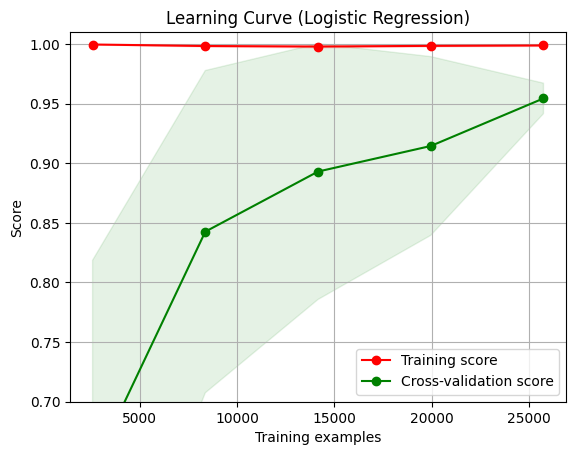

In [104]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    plt.show()

#random forest
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier()

plot_learning_curve(rf_classifier, "Learning Curve (Logistic Regression)", x_train, y_train, ylim=(0.7, 1.01), cv=5, n_jobs=4)

# 6. Model Evaluation

In [105]:
# evaluate with test set
y_pred = logreg_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.8885
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       581
           1       0.92      0.89      0.91       695
           2       0.72      0.87      0.79       159
           3       0.87      0.89      0.88       275
           4       0.92      0.79      0.85       224
           5       0.64      0.88      0.74        66

    accuracy                           0.89      2000
   macro avg       0.84      0.88      0.85      2000
weighted avg       0.90      0.89      0.89      2000

[[536  13   3  19   8   2]
 [  8 620  48   6   2  11]
 [  2  16 139   2   0   0]
 [ 10  15   2 246   2   0]
 [ 12   4   2   9 178  19]
 [  1   3   0   0   4  58]]


In [106]:
y_pred = mnb_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


NameError: name 'mnb_classifier' is not defined

In [ ]:
y_pred = svm_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.571
              precision    recall  f1-score   support

           0       0.75      0.62      0.68       581
           1       0.76      0.57      0.65       695
           2       0.32      0.54      0.40       159
           3       0.50      0.49      0.49       275
           4       0.45      0.55      0.49       224
           5       0.23      0.62      0.33        66

    accuracy                           0.57      2000
   macro avg       0.50      0.57      0.51      2000
weighted avg       0.63      0.57      0.59      2000

[[361  52  43  41  53  31]
 [ 57 397  94  48  52  47]
 [  8  26  86  13  16  10]
 [ 36  25  27 134  27  26]
 [ 16  19  15  26 123  25]
 [  3   5   7   5   5  41]]


In [ ]:
y_pred = xgb_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.585
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       581
           1       0.63      0.70      0.67       695
           2       0.39      0.33      0.36       159
           3       0.54      0.41      0.47       275
           4       0.47      0.43      0.45       224
           5       0.41      0.44      0.43        66

    accuracy                           0.58      2000
   macro avg       0.51      0.50      0.50      2000
weighted avg       0.58      0.58      0.58      2000

[[389 107  14  26  39   6]
 [ 88 489  39  37  29  13]
 [ 22  57  52  13  10   5]
 [ 58  53  15 114  27   8]
 [ 39  55   7  17  97   9]
 [  7  14   6   4   6  29]]


In [ ]:
y_pred = lgb_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.596
              precision    recall  f1-score   support

           0       0.68      0.66      0.67       581
           1       0.65      0.71      0.68       695
           2       0.41      0.40      0.41       159
           3       0.51      0.42      0.46       275
           4       0.48      0.48      0.48       224
           5       0.42      0.45      0.43        66

    accuracy                           0.60      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.59      0.60      0.59      2000

[[383  93  21  37  41   6]
 [ 78 492  40  37  35  13]
 [ 19  45  64  15  12   4]
 [ 48  61  16 116  25   9]
 [ 27  50  10  20 107  10]
 [ 11  13   5   4   3  30]]


In [ ]:
y_pred = adaboost_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.4825
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       581
           1       0.63      0.55      0.59       695
           2       0.25      0.47      0.33       159
           3       0.46      0.37      0.41       275
           4       0.33      0.44      0.38       224
           5       0.20      0.47      0.28        66

    accuracy                           0.48      2000
   macro avg       0.42      0.46      0.42      2000
weighted avg       0.54      0.48      0.50      2000

[[278  98  57  44  70  34]
 [ 68 380  94  44  66  43]
 [  9  35  75  14  18   8]
 [ 30  40  38 103  38  26]
 [ 30  38  23  19  98  16]
 [  9   9   8   2   7  31]]
